## 1. Copyright/Authorship

#### R. & D. Expert: Asif Mehmood
#### Customized PSO for energy optimization
#### Added temperature/humidity constraints
#### Added weather conditions
#### Evaluated energy optimization

## 2. Importing Dependencies

In [31]:
from __future__ import division
import matplotlib as mpl
import random
import math
from Get_params import getUserPrefTemp_Min, getUserPrefTemp_Max
from Get_params import getUserPrefHumid_Min, getUserPrefHumid_Max
from Get_params import getCurrentTemp, getCurrentHumid, getCurrentEnergy, getCurrentTime
from FuzzyModule import FuzzyControl

import os
import calendar
import pandas as pd
import matplotlib.pyplot as plt

## Global Parameters

In [117]:
isNewlyUpdated = True
opt_method = "new" if isNewlyUpdated else "old"

In [118]:
energy_limit_max = 10.0

In [119]:
xsf_total_energy_cost_temp = 0
xsf_total_energy_cost_humi = 0

## Functions

### - Basic functions

In [120]:
def BasicWeightCost_Rules(currFeature):
    BasicFeatureWeight = 0
    if(currFeature == "RH_8"):
        BasicFeatureWeight = 0.0520
    elif(currFeature == "RH_1"):
        BasicFeatureWeight = 0.0515
    elif(currFeature == "RH_out"):
        BasicFeatureWeight = 0.0512
    elif(currFeature == "T3"):
        BasicFeatureWeight = 0.0501
    elif(currFeature == "RH_3"):
        BasicFeatureWeight = 0.0500 #######
    elif(currFeature == "Press_mm_hg"):
        BasicFeatureWeight = 0.4900
    elif(currFeature == "RH_2"):
        BasicFeatureWeight = 0.0484
    elif(currFeature == "RH_7"):
        BasicFeatureWeight = 0.0482
    elif(currFeature == "T2"):
        BasicFeatureWeight = 0.0478
    elif(currFeature == "T_out"):
        BasicFeatureWeight = 0.0478
    elif(currFeature == "RH_6"):
        BasicFeatureWeight = 0.0470
    elif(currFeature == "RH_4"):
        BasicFeatureWeight = 0.0469
    elif(currFeature == "T8"):
        BasicFeatureWeight = 0.0467
    elif(currFeature == "RH_9"):
        BasicFeatureWeight = 0.0465
    elif(currFeature == "RH_5"):
        BasicFeatureWeight = 0.0463
    elif(currFeature == "Tdewpoint"):
        BasicFeatureWeight = 0.0455
    elif(currFeature == "T4"):
        BasicFeatureWeight = 0.0454
    elif(currFeature == "T7"):
        BasicFeatureWeight = 0.0450 #######
    elif(currFeature == "Windspeed"):
        BasicFeatureWeight = 0.0440
    elif(currFeature == "T1"):
        BasicFeatureWeight = 0.0430
    elif(currFeature == "T5"):
        BasicFeatureWeight = 0.0420
    return BasicFeatureWeight

In [121]:
# Temperature Basic Energy Consumption Rules

def BasicCoolingCost_Rules(currTemp):
    BasicTempCost = 0
    # difference 14kW cooling capacity
    if(currTemp < 21.0):
        BasicTempCost = 1.5
    elif(currTemp <= 22.0 and currTemp >= 21.0):
        BasicTempCost = 1.34 
    elif(currTemp <= 23.0 and currTemp >= 22.0):
        BasicTempCost = 1.22
    elif(currTemp <= 24.0 and currTemp >= 23.0):
        BasicTempCost = 1.08
    elif(currTemp <= 25.0 and currTemp >= 24.0):
        BasicTempCost = 0.99
    elif(currTemp >= 25.0):
        BasicTempCost = 0.98
    return BasicTempCost

In [122]:
# Humidity Basic Energy Consumption Rules

def BasicHumidCost_Rules(currHumid):
    BasicHumidityCost = 0
    if(currHumid < 40.0):
        BasicHumidityCost = 0.98
    elif(currHumid <= 45.0 and currHumid >= 40.0):
        BasicHumidityCost = 0.99 
    elif(currHumid <= 50.0 and currHumid >= 45.0):
        BasicHumidityCost = 1.08
    elif(currHumid <= 55.0 and currHumid >= 50.0):
        BasicHumidityCost = 1.22
    elif(currHumid <= 60.0 and currHumid >= 55.0):
        BasicHumidityCost = 1.34
    elif(currHumid >= 60.0):
        BasicHumidityCost = 1.5
    return BasicHumidityCost

In [123]:
# Minimize Energy Consumption COST FUNCTION

def EnergyMin(x):
    energycost = 0
    for i in range(len(x)):
        
        energyTemp = BasicCoolingCost_Rules(x[0])
        weightTemp = BasicWeightCost_Rules("T7")
        
        energyHumid = BasicHumidCost_Rules(x[1])
        weightHumid = BasicWeightCost_Rules("RH_3")
        
        weightEnergyAirPressure = BasicWeightCost_Rules("Press_mm_hg")
        
        weightEnergyDewpoint = BasicWeightCost_Rules("Tdewpoint")
        
        weightEnergyWindspeed = BasicWeightCost_Rules("Windspeed")
        
        if (isNewlyUpdated): # Asif
            energycost = energyTemp*weightTemp + energyHumid*weightHumid + weightEnergyAirPressure + weightEnergyDewpoint + weightEnergyWindspeed
        else:
            energycost = energyTemp + energyHumid
    return energycost

In [124]:
# COST FUNCTION

# function we are attempting to optimize (minimize)
def func1(x):
    total=0
    for i in range(len(x)):
        total+=x[i]**2
    return total

### - PSO-based functions

In [125]:
# Particle Class (that is used by PSO)

class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]

In [126]:
def PSO(costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions=len(x0)
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # begin optimization loop
        i=0
        while i < maxiter:
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1
        return pos_best_g, err_best_g

## Simulation (Energy Optimization)

### - Months

In [127]:
###asif### print("\nGoing to setup matplotlib figure opening limit '{:}'".format("max_open_warning = 0"))
mpl.rc('figure', max_open_warning = 0)
# mpl.rcParams.update({'figure.max_open_warning': 0})
###asif### print("Successfully setup matplotlib figure opening limit\n")

# temp , humid
###asif### print("--------------- Updated Optimization starts (considers ---------------")
###asif### print("--------------- outdoor and indoor temperature//humidity, ------------")
###asif### print("--------------- seasonal, and weather parameters. It also ------------")
###asif### print("--------------- considers the weight factors of each feature) --------")
min_temp = getUserPrefTemp_Min()
max_temp = getUserPrefTemp_Max()
min_humid = getUserPrefHumid_Min()
max_humid = getUserPrefHumid_Max()

###asif### print ('- Temperature Range [Min, Max]: [' + str(min_temp)+", "+ str(max_temp)+"]")
###asif### print ('- Humidity Range [Min, Max]: [' + str(min_humid)+", "+ str(max_humid)+"]")

######### months settings
# sim = 744  # , i.e., one month simulation
# sim = 1464 # , i.e., two month simulation
# sim = 2208 # , i.e., three month simulation
# sim = 2952 # , i.e., four month simulation
# sim = 3672 # , i.e., five month simulation
# sim = 4416 # , i.e., six month simulation
# sim = 5136 # , i.e., seven month simulation
# sim = 5880 # , i.e., eight month simulation
# sim = 6624 # , i.e., nine month simulation
# sim = 7296 # , i.e., ten month simulation
# sim = 8040 # , i.e., eleven month simulation
# sim = 8760 # , i.e., 12 month simulation
sim = sim if sim > 500 else 500
sim_check = (sim-2)

sim = 122  # , i.e., second dataset simulation

directory_sim_results = "results/{:}_simulations/{:}/".format(sim, opt_method)
if (not os.path.exists(directory_sim_results)):
    os.makedirs(directory_sim_results)

tasks_f_postfix = "tasks-temphumid.txt"
tasks_filename = "opt_{:} sim_{:} {:}".format(
    opt_method,
    sim,
    tasks_f_postfix,
)
tasks_filename_fqdn = directory_sim_results+tasks_filename
f = open(tasks_filename_fqdn, "w")
f.close()

temphumid_f_postfix = "dataframe-temphumid.txt"
temphumid_filename = " opt_{:} sim_{:} {:}".format(
    opt_method,
    sim,
    temphumid_f_postfix,
)
temphumid_filename_fqdn = directory_sim_results+temphumid_filename
f = open(temphumid_filename_fqdn, "w")
f.writelines("Sim,TempRead,TempControl,HumidRead,HumidControl\n")
f.close()

graph_f_prefix = "opt_{:} sim_{:} ".format(
    opt_method,
    sim,
)

err_best_g_total = 0
for index in range (0,sim):
    ###asif### print("\n")
    ###asif### print("-------------- Simulation iteration : "+str(index+1)+" -----------------")
    #print (index)
    curr_temp = float(getCurrentTemp(index))
    curr_humid = float(getCurrentHumid(index))
    # curr_energy = float(getCurrentEnergy(index))

    ###asif### print ('Current:')
    ###asif### print ('- Temperature: ' + str(curr_temp), end = "\t")
    ###asif### print ('- Humidity: ' + str(curr_humid), end = "\t")
    # print ('- Current Energy: ' + str(curr_energy))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("TempRead "+str(curr_temp)+"\n")
    f.writelines("humidRead "+str(curr_humid)+"\n")
    f.close()

    initial=[curr_temp,curr_humid]               # initial starting location [temp,humidity...]
    bounds=[(min_temp,max_temp),(min_humid,max_humid)]  # input bounds [(temp_min,temp_max),(humidity_min,humidity_max)...]

    pos_best_g, err_best_g = PSO(EnergyMin,initial,bounds,num_particles=15,maxiter=100)

    err_best_g_total += err_best_g
    # print final results
    ###asif### print ('Optimization:')
    ###asif### print ('- positions [T, H]: ' + str(pos_best_g), end = "\t")
    ###asif### print ('- error: ' + str(err_best_g), end = "\t")
    ###asif### print ('- error (total): ' + str(err_best_g_total))

    FuzzyTemp, FuzzyHumid = FuzzyControl(pos_best_g[0], pos_best_g[1], index, simulationsCheck = sim_check, figPath = directory_sim_results, figFilePre = graph_f_prefix, exp="Months")

    # if (index > sim_check):
    #     val = input("\nHere Enter (avg-temp/humidity): ")
    
    ###asif### print("Fuzzy-based Generated Tasks, Set:")
    ###asif### print("- Temperature Control: "+str(FuzzyTemp), end = "\t")
    ###asif### print("- Humidity Control: "+str(FuzzyHumid))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("tempControl "+str(FuzzyTemp)+"\n")
    f.writelines("humidControl "+str(FuzzyHumid)+"\n")
    f.close()
    
    f = open(temphumid_filename_fqdn, "a")
    f.writelines(str(index+1)+","+str(curr_temp)+","+str(FuzzyTemp)+","+str(curr_humid)+","+str(FuzzyHumid)+"\n")
    f.close()

err_best_g_total = round(err_best_g_total, 2)

tasks_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    sim,
    err_best_g_total,
    tasks_f_postfix,
)
tasks_filename_fqdn_updated = directory_sim_results+tasks_filename_updated
os.rename(tasks_filename_fqdn, tasks_filename_fqdn_updated)

temphumid_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    sim,
    err_best_g_total,
    temphumid_f_postfix,
)
temphumid_filename_fqdn_updated = directory_sim_results+temphumid_filename_updated
os.rename(temphumid_filename_fqdn, temphumid_filename_fqdn_updated)

graph_filelist = os.listdir(directory_sim_results)
for graph_index, graph_file in enumerate(graph_filelist[:]):
    if graph_file.endswith(".png"):
        graph_file_splits = graph_file.split(" ")
        graph_filename_fqdn_updated = directory_sim_results+"{:} {:} {:} {:}".format(
            graph_file_splits[0],
            graph_file_splits[1],
            "cost_"+str(err_best_g_total),
            graph_file_splits[2],
        )
        os.rename(directory_sim_results+graph_file, graph_filename_fqdn_updated)

In [128]:
mainDF = pd.read_csv(temphumid_filename_fqdn_updated)
tempControlDF = mainDF.drop(columns = ["Sim", "HumidRead", "HumidControl"]).copy(deep = True)
humidControlDF = mainDF.drop(columns = ["Sim", "TempRead", "TempControl"]).copy(deep = True)

In [129]:
tempControlDF

,TempRead,TempControl
0,3.0,22.768895
1,-1.0,22.768895
2,-3.0,22.768895
3,-4.0,22.768895
4,-5.0,22.768895
...,...,...
117,4.0,22.768895
118,10.0,22.768895
119,14.0,22.768895
120,12.0,22.768895


In [94]:
graph_temp_f_postfix = "graph-temp.png"
graph_temp_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    sim,
    err_best_g_total,
    graph_temp_f_postfix,
)
graph_temp_filename_fqdn = directory_sim_results+graph_temp_filename
tempaxis = tempControlDF.plot(figsize=(15, 7))
tempaxis.text(
    70,
    max(tempControlDF.TempRead)-0.5,
    "Actual and control temperature (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_temp_filename_fqdn)

In [130]:
humidControlDF

,HumidRead,HumidControl
0,30.0,57.957692
1,45.0,56.657394
2,60.0,50.472927
3,75.0,49.560420
4,80.0,49.560420
...,...,...
117,50.0,53.986292
118,25.0,57.957692
119,20.0,57.957692
120,30.0,57.957692


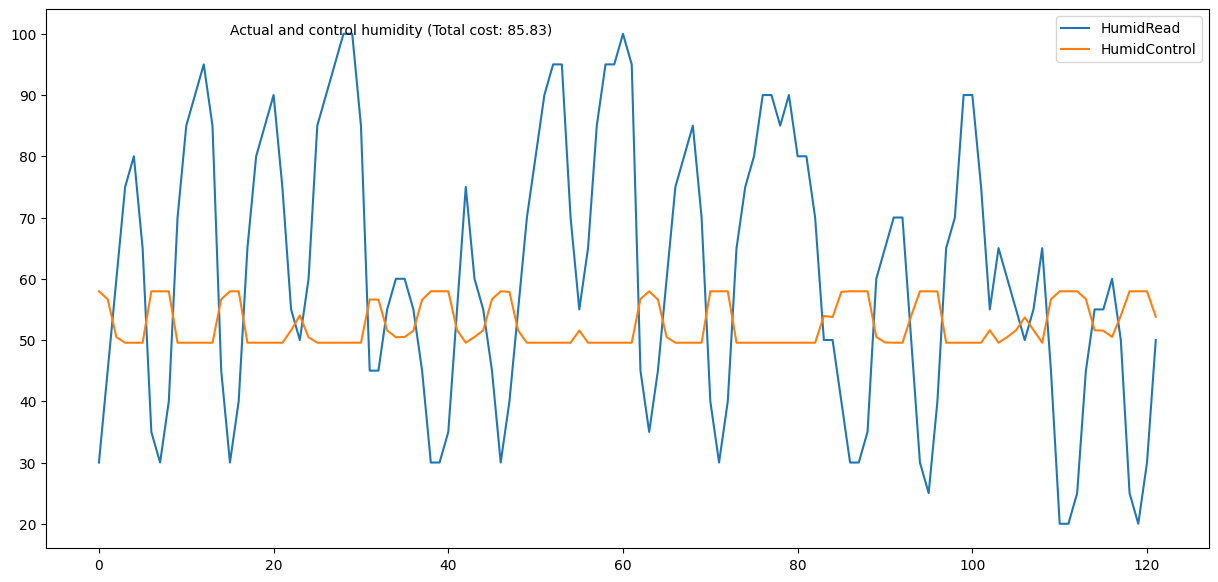

In [131]:
graph_humid_f_postfix = "graph-humid.png"
graph_humid_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    sim,
    err_best_g_total,
    graph_humid_f_postfix,
)
graph_humid_filename_fqdn = directory_sim_results+graph_humid_filename
humidaxis = humidControlDF.plot(figsize=(15, 7))
humidaxis.text(
    15,
    max(humidControlDF.HumidRead),
    "Actual and control humidity (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_humid_filename_fqdn)

### - Monthwise

/home/xsif/anaconda3/envs/env005_energypredappliances/lib/python3.10/site-packages/skfuzzy/control/term.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/xsif/anaconda3/envs/env005_energypredappliances/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


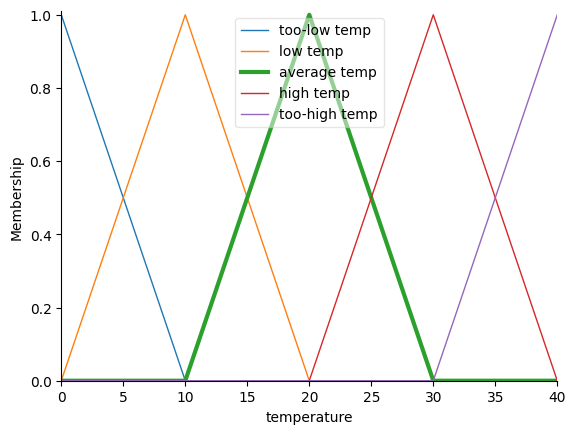

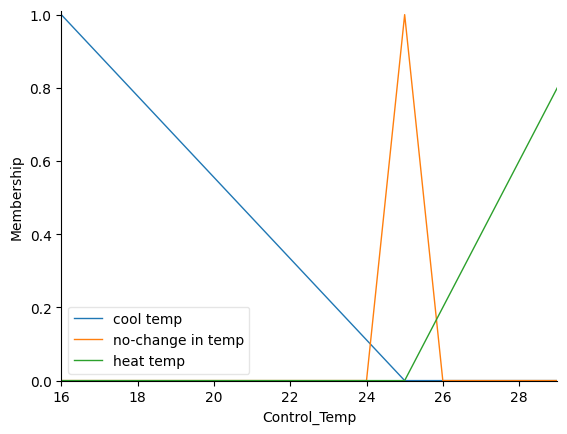

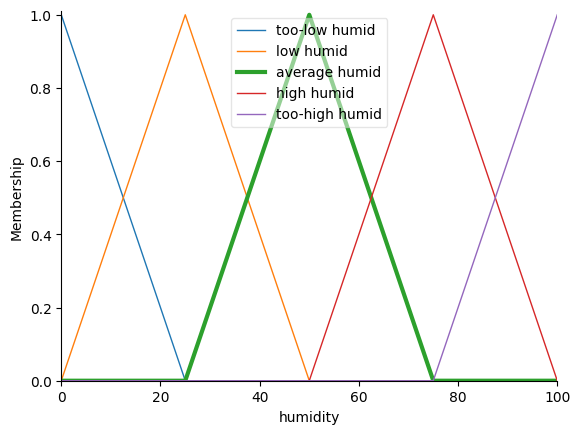

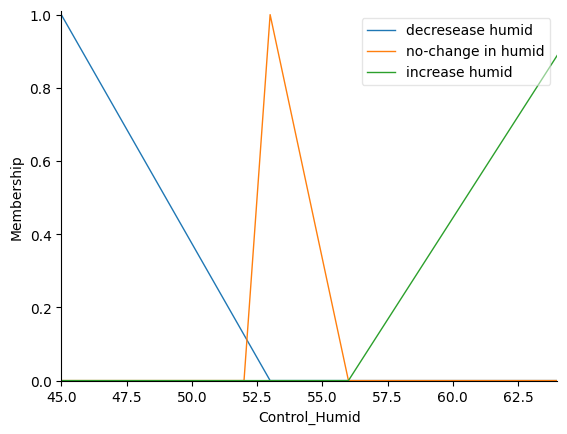

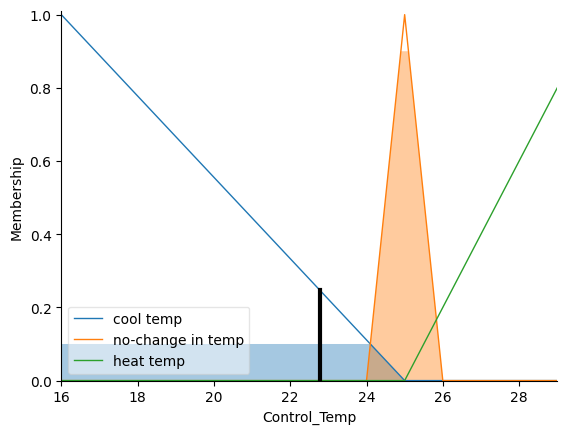

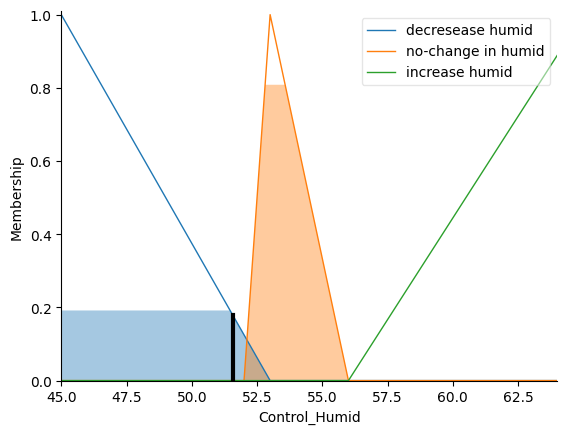

In [97]:
###asif### print("\nGoing to setup matplotlib figure opening limit '{:}'".format("max_open_warning = 0"))
mpl.rc('figure', max_open_warning = 0)
# mpl.rcParams.update({'figure.max_open_warning': 0})
###asif### print("Successfully setup matplotlib figure opening limit\n")

# temp , humid
###asif### print("--------------- Updated Optimization starts (considers ---------------")
###asif### print("--------------- outdoor and indoor temperature//humidity, ------------")
###asif### print("--------------- seasonal, and weather parameters. It also ------------")
###asif### print("--------------- considers the weight factors of each feature) --------")
min_temp = getUserPrefTemp_Min()
max_temp = getUserPrefTemp_Max()
min_humid = getUserPrefHumid_Min()
max_humid = getUserPrefHumid_Max()

###asif### print ('- Temperature Range [Min, Max]: [' + str(min_temp)+", "+ str(max_temp)+"]")
###asif### print ('- Humidity Range [Min, Max]: [' + str(min_humid)+", "+ str(max_humid)+"]")

######### monthwise settings
year = 2023
month = 3
sim_data = pd.read_csv("results/Monthwise/Monthwise-Data/data-{:}-{:}.csv".format(year, month))
sim_data = sim_data.astype({
    "appl":"float",
    "temp":"float",
    "reh":"float",
})
sim = len(sim_data)
# sim = sim if sim > 500 else 500
sim_check = (sim-2)

directory_sim_results = "results/{:}_simulations/{:}/".format(str(year)+"-"+calendar.month_name[month], opt_method)
if (not os.path.exists(directory_sim_results)):
    os.makedirs(directory_sim_results)

tasks_f_postfix = "tasks-temphumid.txt"
tasks_filename = "opt_{:} sim_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    tasks_f_postfix,
)
tasks_filename_fqdn = directory_sim_results+tasks_filename
f = open(tasks_filename_fqdn, "w")
f.close()

temphumid_f_postfix = "dataframe-temphumid.txt"
temphumid_filename = " opt_{:} sim_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    temphumid_f_postfix,
)
temphumid_filename_fqdn = directory_sim_results+temphumid_filename
f = open(temphumid_filename_fqdn, "w")
f.writelines("Sim,TempRead,TempControl,HumidRead,HumidControl\n")
f.close()

graph_f_prefix = "opt_{:} sim_{:} ".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
)

err_best_g_total = 0

for index, data in sim_data.iterrows():
    curr_temp = sim_data["temp"].iloc[index]
    curr_humid = sim_data["reh"].iloc[index]
    curr_energy = sim_data["appl"].iloc[index]
    # print ('Current:', index)
    # print ('- Temperature: ' + str(curr_temp), end = "\t")
    # print ('- Humidity: ' + str(curr_humid), end = "\t")
    # print ('- Current Energy: ' + str(curr_energy))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("TempRead "+str(curr_temp)+"\n")
    f.writelines("humidRead "+str(curr_humid)+"\n")
    f.close()

    initial=[curr_temp,curr_humid]               # initial starting location [temp,humidity...]
    bounds=[(min_temp,max_temp),(min_humid,max_humid)]  # input bounds [(temp_min,temp_max),(humidity_min,humidity_max)...]

    pos_best_g, err_best_g = PSO(EnergyMin,initial,bounds,num_particles=15,maxiter=100)

    err_best_g_total += err_best_g
    # print final results
    # print ('Optimization:')
    # print ('- positions [T, H]: ' + str(pos_best_g), end = "\t")
    # print ('- error: ' + str(err_best_g), end = "\t")
    # print ('- error (total): ' + str(err_best_g_total))

    FuzzyTemp, FuzzyHumid = FuzzyControl(pos_best_g[0], pos_best_g[1], index, simulationsCheck = sim_check, figPath = directory_sim_results, figFilePre = graph_f_prefix, exp="Monthwise")

    # if (index > sim_check):
    #     val = input("\nHere Enter (avg-temp/humidity): ")
    
    # print("Fuzzy-based Generated Tasks, Set:")
    # print("- Temperature Control: "+str(FuzzyTemp), end = "\t")
    # print("- Humidity Control: "+str(FuzzyHumid))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("tempControl "+str(FuzzyTemp)+"\n")
    f.writelines("humidControl "+str(FuzzyHumid)+"\n")
    f.close()
    
    f = open(temphumid_filename_fqdn, "a")
    f.writelines(str(index+1)+","+str(curr_temp)+","+str(FuzzyTemp)+","+str(curr_humid)+","+str(FuzzyHumid)+"\n")
    f.close()

err_best_g_total = round(err_best_g_total, 2)

tasks_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    err_best_g_total,
    tasks_f_postfix,
)
tasks_filename_fqdn_updated = directory_sim_results+tasks_filename_updated
os.rename(tasks_filename_fqdn, tasks_filename_fqdn_updated)

temphumid_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    err_best_g_total,
    temphumid_f_postfix,
)
temphumid_filename_fqdn_updated = directory_sim_results+temphumid_filename_updated
os.rename(temphumid_filename_fqdn, temphumid_filename_fqdn_updated)

# print (directory_sim_results)

graph_filelist = os.listdir(directory_sim_results)
for graph_index, graph_file in enumerate(graph_filelist[:]):
    if graph_file.endswith(".png"):
        graph_file_splits = graph_file.split(" ")
        graph_filename_fqdn_updated = directory_sim_results+"{:} {:} {:} {:}".format(
            graph_file_splits[0],
            graph_file_splits[1],
            "cost_"+str(err_best_g_total),
            graph_file_splits[2],
        )
        os.rename(directory_sim_results+graph_file, graph_filename_fqdn_updated)

In [98]:
mainDF = pd.read_csv(temphumid_filename_fqdn_updated)
tempControlDF = mainDF.drop(columns = ["Sim", "HumidRead", "HumidControl"]).copy(deep = True)
humidControlDF = mainDF.drop(columns = ["Sim", "TempRead", "TempControl"]).copy(deep = True)

In [99]:
tempControlDF

,TempRead,TempControl
0,3.0,22.768895
1,4.0,22.768895
2,5.0,22.768895
3,7.0,22.768895
4,8.0,22.768895
...,...,...
91,10.0,22.768895
92,14.0,22.768895
93,12.0,22.768895
94,7.0,22.768895


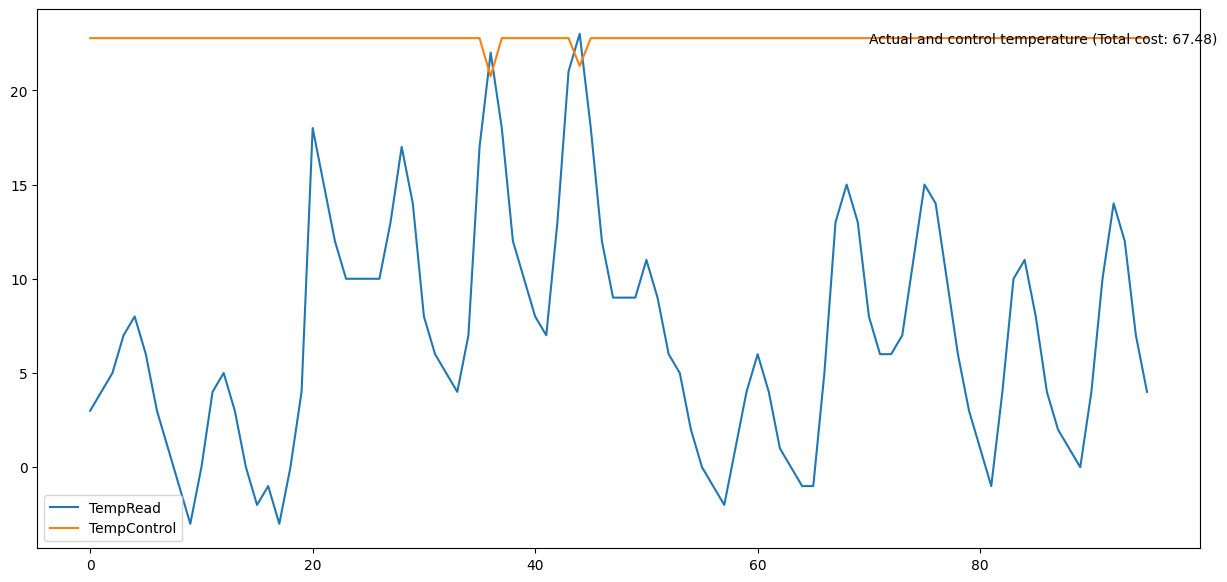

In [100]:
graph_temp_f_postfix = "graph-temp.png"
graph_temp_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    err_best_g_total,
    graph_temp_f_postfix,
)
graph_temp_filename_fqdn = directory_sim_results+graph_temp_filename
tempaxis = tempControlDF.plot(figsize=(15, 7))
tempaxis.text(
    70,
    max(tempControlDF.TempRead)-0.5,
    "Actual and control temperature (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_temp_filename_fqdn)

In [101]:
humidControlDF

,HumidRead,HumidControl
0,95.0,49.560420
1,100.0,49.560420
2,100.0,49.560420
3,85.0,49.560420
4,45.0,56.569131
...,...,...
91,25.0,57.957692
92,20.0,57.957692
93,30.0,57.957692
94,50.0,53.878105


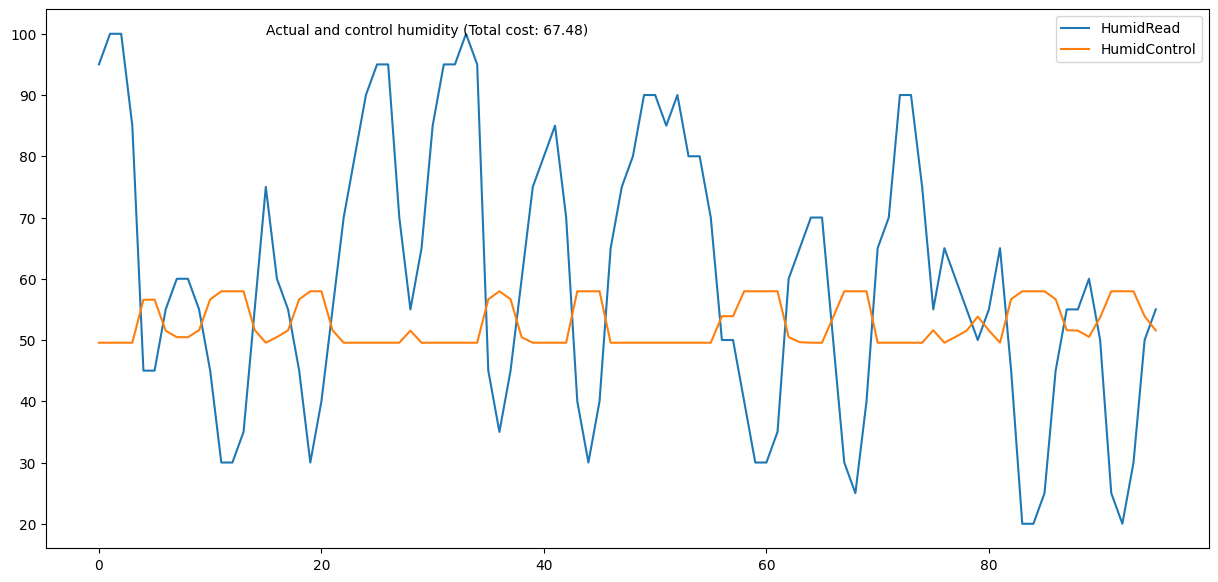

In [102]:
graph_humid_f_postfix = "graph-humid.png"
graph_humid_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    str(year)+"-"+calendar.month_name[month],
    err_best_g_total,
    graph_humid_f_postfix,
)
graph_humid_filename_fqdn = directory_sim_results+graph_humid_filename
humidaxis = humidControlDF.plot(figsize=(15, 7))
humidaxis.text(
    15,
    max(humidControlDF.HumidRead),
    "Actual and control humidity (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_humid_filename_fqdn)

## Seasonwise

/home/xsif/anaconda3/envs/env005_energypredappliances/lib/python3.10/site-packages/skfuzzy/control/term.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/xsif/anaconda3/envs/env005_energypredappliances/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


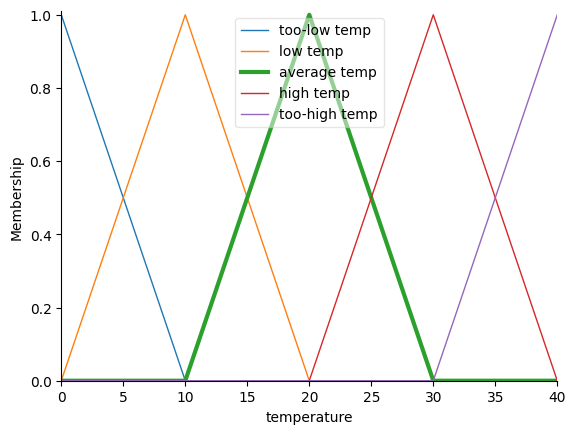

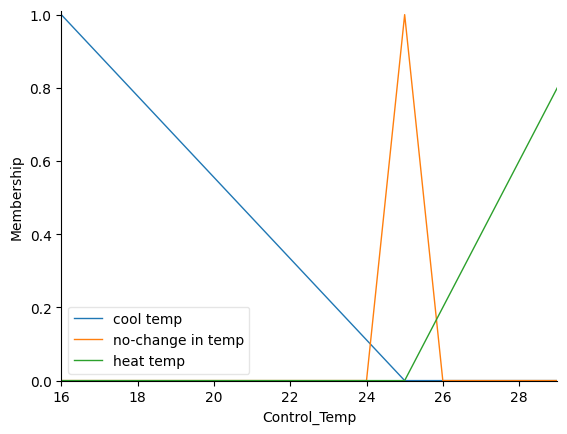

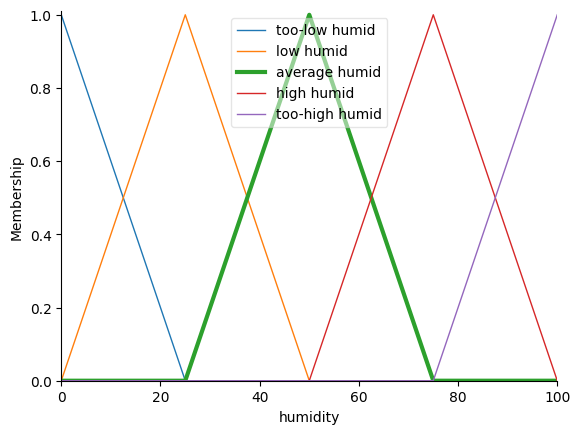

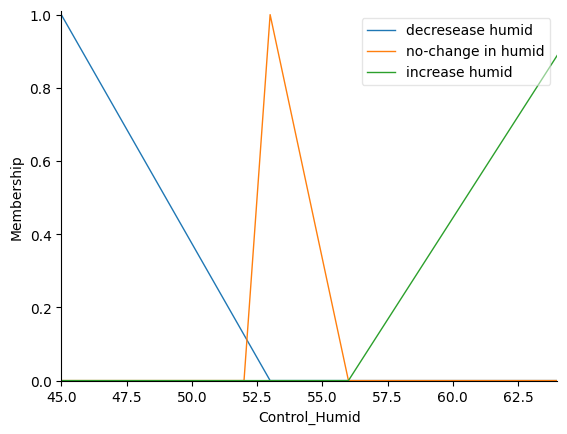

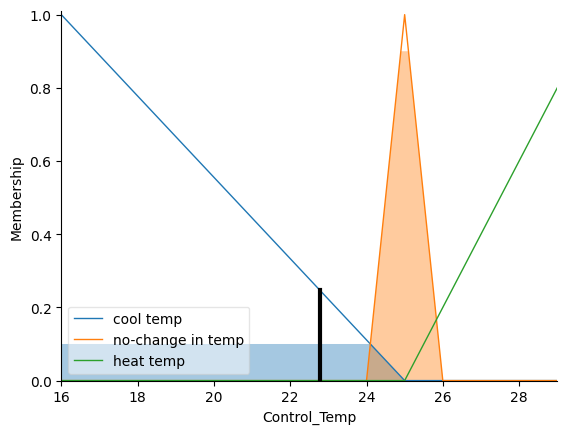

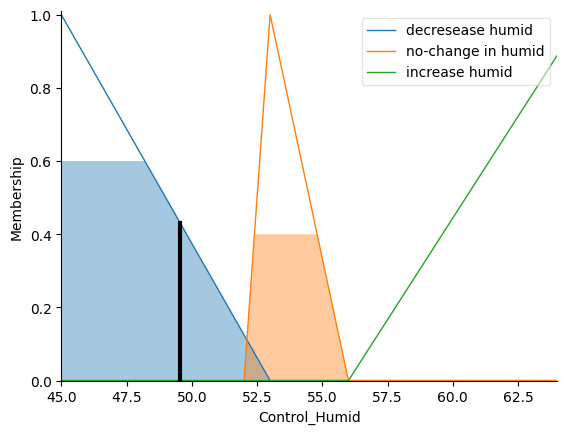

In [24]:
###asif### print("\nGoing to setup matplotlib figure opening limit '{:}'".format("max_open_warning = 0"))
mpl.rc('figure', max_open_warning = 0)
# mpl.rcParams.update({'figure.max_open_warning': 0})
###asif### print("Successfully setup matplotlib figure opening limit\n")

# temp , humid
###asif### print("--------------- Updated Optimization starts (considers ---------------")
###asif### print("--------------- outdoor and indoor temperature//humidity, ------------")
###asif### print("--------------- seasonal, and weather parameters. It also ------------")
###asif### print("--------------- considers the weight factors of each feature) --------")
min_temp = getUserPrefTemp_Min()
max_temp = getUserPrefTemp_Max()
min_humid = getUserPrefHumid_Min()
max_humid = getUserPrefHumid_Max()

###asif### print ('- Temperature Range [Min, Max]: [' + str(min_temp)+", "+ str(max_temp)+"]")
###asif### print ('- Humidity Range [Min, Max]: [' + str(min_humid)+", "+ str(max_humid)+"]")

######### seasonwise settings
seasons = {
    "spring-2014":{"start":{"year":2014, "month":3}, "end":{"year":2014, "month":5}},
    "summer-2014":{"start":{"year":2014, "month":6}, "end":{"year":2014, "month":8}},
    "autumn-2014":{"start":{"year":2014, "month":9}, "end":{"year":2014, "month":11}},
    "winter-2014-2015":{"start":{"year":2014, "month":12}, "end":{"year":2015, "month":2}},
    "spring-2015":{"start":{"year":2015, "month":3}, "end":{"year":2015, "month":5}},
}
season_name = "spring-2014"
current_season = seasons[season_name]
yearstart, yearend = current_season["start"]["year"], current_season["end"]["year"]
monthstart, monthend = current_season["start"]["month"], current_season["end"]["month"]

sim_data = pd.read_csv("results/Seasonwise/Seasonwise-Data/data-{:}-{:}-{:}.txt".format(
    season_name, calendar.month_abbr[monthstart], calendar.month_abbr[monthend]
))
sim_data = sim_data.astype({
    "KWH":"float",
    "TemperatureC":"float",
    "Humidity":"float",
})
sim = len(sim_data)
sim = sim if sim > 500 else 500
sim_check = (sim-2)

directory_sim_results = "results/{:}_simulations/{:}/".format(
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend], opt_method
)
if (not os.path.exists(directory_sim_results)):
    os.makedirs(directory_sim_results)

tasks_f_postfix = "tasks-temphumid.txt"
tasks_filename = "opt_{:} sim_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    tasks_f_postfix,
)
tasks_filename_fqdn = directory_sim_results+tasks_filename
f = open(tasks_filename_fqdn, "w")
f.close()

temphumid_f_postfix = "dataframe-temphumid.txt"
temphumid_filename = "opt_{:} sim_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    temphumid_f_postfix,
)
temphumid_filename_fqdn = directory_sim_results+temphumid_filename
f = open(temphumid_filename_fqdn, "w")
f.writelines("Sim,TempRead,TempControl,HumidRead,HumidControl\n")
f.close()

graph_f_prefix = "opt_{:} sim_{:} ".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
)

err_best_g_total = 0

for index, data in sim_data.iterrows():
    curr_temp = sim_data["TemperatureC"].iloc[index]
    curr_humid = sim_data["Humidity"].iloc[index]
    curr_energy = sim_data["KWH"].iloc[index]
    # print ('Current:', index)
    # print ('- Temperature: ' + str(curr_temp), end = "\t")
    # print ('- Humidity: ' + str(curr_humid), end = "\t")
    # print ('- Current Energy: ' + str(curr_energy))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("TempRead "+str(curr_temp)+"\n")
    f.writelines("humidRead "+str(curr_humid)+"\n")
    f.close()

    initial=[curr_temp,curr_humid]               # initial starting location [temp,humidity...]
    bounds=[(min_temp,max_temp),(min_humid,max_humid)]  # input bounds [(temp_min,temp_max),(humidity_min,humidity_max)...]

    pos_best_g, err_best_g = PSO(EnergyMin,initial,bounds,num_particles=15,maxiter=100)

    err_best_g_total += err_best_g
    # # print final results
    # print ('Optimization:')
    # print ('- positions [T, H]: ' + str(pos_best_g), end = "\t")
    # print ('- error: ' + str(err_best_g), end = "\t")
    # print ('- error (total): ' + str(err_best_g_total))

    FuzzyTemp, FuzzyHumid = FuzzyControl(pos_best_g[0], pos_best_g[1], index, simulationsCheck = sim_check, figPath = directory_sim_results, figFilePre = graph_f_prefix, exp="Monthwise")

    # if (index > sim_check):
    #     val = input("\nHere Enter (avg-temp/humidity): ")
    
    # print("Fuzzy-based Generated Tasks, Set:")
    # print("- Temperature Control: "+str(FuzzyTemp), end = "\t")
    # print("- Humidity Control: "+str(FuzzyHumid))

    f = open(tasks_filename_fqdn, "a")
    f.writelines("tempControl "+str(FuzzyTemp)+"\n")
    f.writelines("humidControl "+str(FuzzyHumid)+"\n")
    f.close()
    
    f = open(temphumid_filename_fqdn, "a")
    f.writelines(str(index+1)+","+str(curr_temp)+","+str(FuzzyTemp)+","+str(curr_humid)+","+str(FuzzyHumid)+"\n")
    f.close()

err_best_g_total = round(err_best_g_total, 2)

tasks_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    err_best_g_total,
    tasks_f_postfix,
)
tasks_filename_fqdn_updated = directory_sim_results+tasks_filename_updated
os.rename(tasks_filename_fqdn, tasks_filename_fqdn_updated)

temphumid_filename_updated = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    err_best_g_total,
    temphumid_f_postfix,
)
temphumid_filename_fqdn_updated = directory_sim_results+temphumid_filename_updated
os.rename(temphumid_filename_fqdn, temphumid_filename_fqdn_updated)

# print (directory_sim_results)

graph_filelist = os.listdir(directory_sim_results)
for graph_index, graph_file in enumerate(graph_filelist[:]):
    if graph_file.endswith(".png"):
        graph_file_splits = graph_file.split(" ")
        graph_filename_fqdn_updated = directory_sim_results+"{:} {:} {:} {:}".format(
            graph_file_splits[0],
            graph_file_splits[1],
            "cost_"+str(err_best_g_total),
            graph_file_splits[2],
        )
        os.rename(directory_sim_results+graph_file, graph_filename_fqdn_updated)

In [25]:
mainDF = pd.read_csv(temphumid_filename_fqdn_updated)
tempControlDF = mainDF.drop(columns = ["Sim", "HumidRead", "HumidControl"]).copy(deep = True)
humidControlDF = mainDF.drop(columns = ["Sim", "TempRead", "TempControl"]).copy(deep = True)

In [26]:
tempControlDF

,TempRead,TempControl
0,3.90,22.768895
1,4.15,22.768895
2,3.90,22.768895
3,3.60,22.768895
4,3.30,22.768895
...,...,...
739,22.25,21.725158
740,20.95,22.422001
741,21.05,22.725144
742,20.85,22.768895


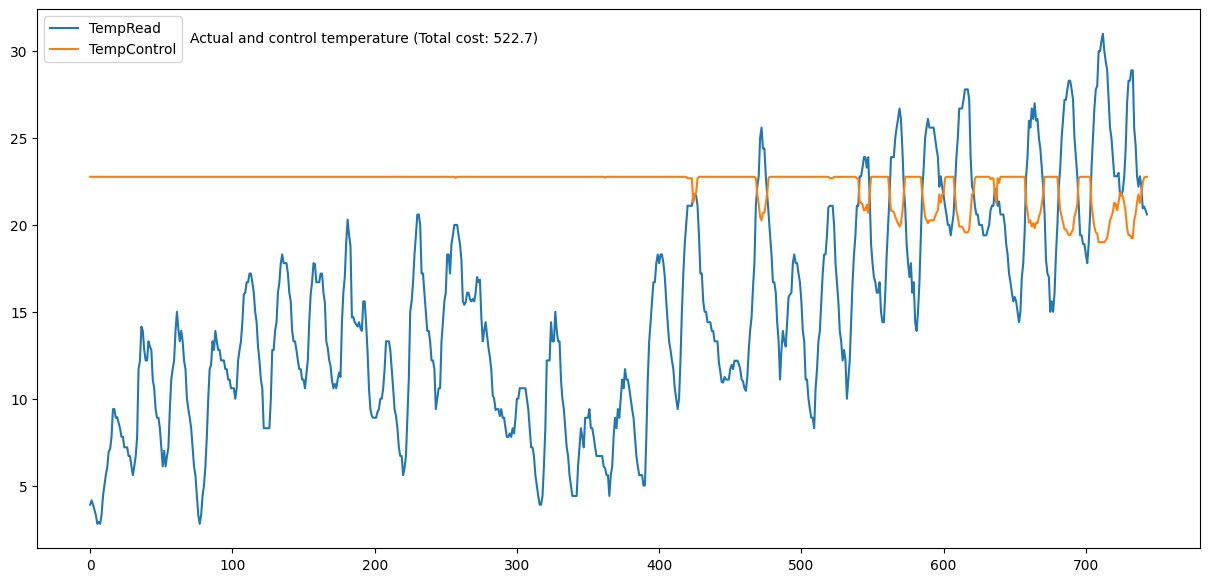

In [27]:
graph_temp_f_postfix = "graph-temp.png"
graph_temp_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    err_best_g_total,
    graph_temp_f_postfix,
)
graph_temp_filename_fqdn = directory_sim_results+graph_temp_filename
tempaxis = tempControlDF.plot(figsize=(15, 7))
tempaxis.text(
    70,
    max(tempControlDF.TempRead)-0.5,
    "Actual and control temperature (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_temp_filename_fqdn)

In [28]:
humidControlDF

,HumidRead,HumidControl
0,100.0,49.560420
1,96.5,49.560420
2,100.0,49.560420
3,96.5,49.560420
4,97.0,49.560420
...,...,...
739,85.5,47.997934
740,93.0,49.560420
741,92.0,47.873535
742,93.0,49.560420


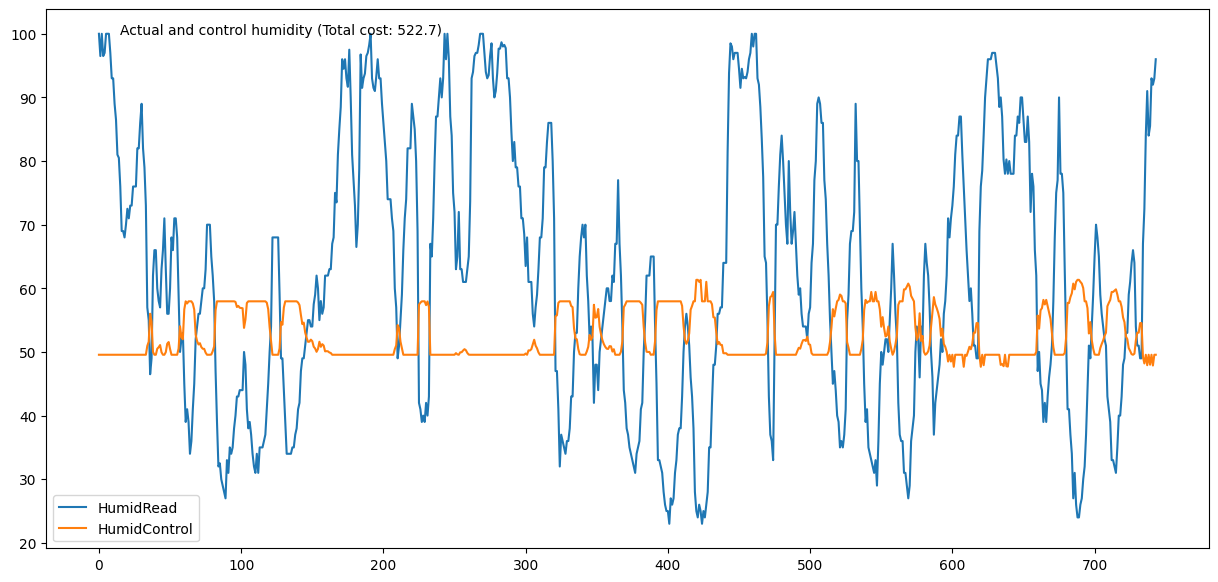

In [29]:
graph_humid_f_postfix = "graph-humid.png"
graph_humid_filename = "opt_{:} sim_{:} cost_{:} {:}".format(
    opt_method,
    season_name+"-"+calendar.month_abbr[monthstart]+"-"+calendar.month_abbr[monthend],
    err_best_g_total,
    graph_humid_f_postfix,
)
graph_humid_filename_fqdn = directory_sim_results+graph_humid_filename
humidaxis = humidControlDF.plot(figsize=(15, 7))
humidaxis.text(
    15,
    max(humidControlDF.HumidRead),
    "Actual and control humidity (Total cost: {:})".format(err_best_g_total)
)
plt.savefig(graph_humid_filename_fqdn)

In [1]:
fullname = "aaaa aa"
fullname = fullname.replace(" ", "")
print (fullname)

aaaaaa
